In [143]:
from __future__ import division
import plotly as ply
import pandas as pd
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from sklearn.cluster import KMeans

In [144]:
import pyodbc

driver = '{SQL Server Native Client 11.0}'
server = 'SERVER'
db1 = 'DB'
tcon = 'yes'


cnxn = pyodbc.connect(driver=driver, 
                      host=server, database=db1, trusted_connection=tcon
                      )

reg = pd.read_sql_query('select * from mytable', cnxn)



In [146]:
reg = reg.set_index('ID')


# Visualizing the data



In [149]:
def grouping(col):
    g = reg[reg['cust_type'] == 'G'][col]
    d = reg[reg['cust_type'] == 'D'][col]
    return g,d


In [2]:
#from matplotlib.pyplot import figure
#figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
#plt.hist(grouping('Recency')[0], bins=25, alpha=0.5, label='G', color='b')
#plt.hist(grouping('Recency')[1], bins=25, alpha=0.5, label='D', color='r')
#plt.legend(loc='upper right')
#plt.title('Customer Recency')
#plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)

In [3]:
##from matplotlib.pyplot import figure
##figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
##plt.hist(grouping('max_lag')[0], bins=25, alpha=0.5, label='G', color='b')
##plt.hist(grouping('max_lag')[1], bins=25, alpha=0.5, label='D', color='r')
##plt.legend(loc='upper right')
##plt.title('Customer Max Lag')
#plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)

# Data Cleaning

In [148]:
reg = reg[(reg['dis_per_v']<0) & (reg['dis_per_v']>-50) & (reg['f']>2) 
                                                                   & (reg['f']<50) & (reg['V']<1500)]

In [4]:
#from matplotlib.pyplot import figure
#figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
#plt.hist(grouping('dis_per_v')[0], bins=25, alpha=0.5, label='G', color='b')
#plt.hist(grouping('dis_per_v')[1], bins=25, alpha=0.5, label='D', color='r')
#plt.legend(loc='upper right')
#plt.title('Customer discount per visit')
#plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)

# Kmeans Clustering

Text(0.5, 1.0, 'Recency Elbow curve')

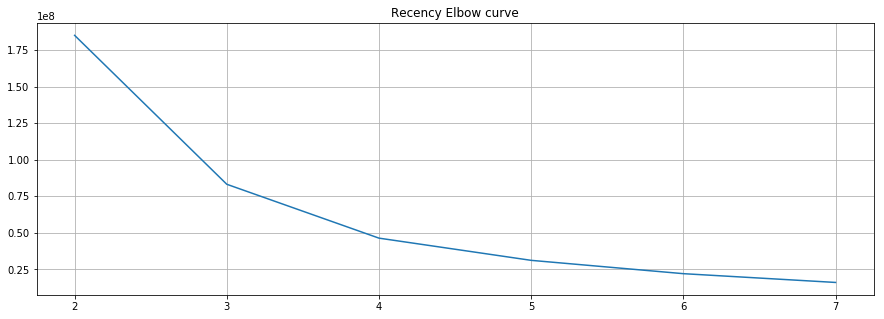

In [22]:
# First we find the optimal number of clusters using the elbow method
# Remember to set the random state to reproduce
#The location of a bend (knee) in the plot is generally considered as an indicator of the appropriate number of clusters.
# looks like k=5 is the optimal number

df_recency = reg[['Recency']]
#df_normalized[['Recency']]

distorsions = []
for k in range(2, 8):
    kmeans = KMeans(n_clusters=k,random_state=10,n_jobs = -1)
    kmeans.fit(df_recency)
    distorsions.append(kmeans.inertia_)

fig = plt.figure(figsize=(15, 5))
plt.plot(range(2, 8), distorsions)
plt.grid(True)
plt.title('Recency Elbow curve')


In [50]:
# Also checking the number of optimal cluster with silhouette
#The optimal number of clusters is the one that maximize the average silhouette over a range of possible values for k. 

#from sklearn.metrics import silhouette_samples, silhouette_score

#df_recency = reg[['Recency']]
#df_normalized[['Recency']]

#silhouette_avg = []
#for k in range(2, 5):
 #   kmeans = KMeans(n_clusters=k,random_state=10,n_jobs = -1)
 #   cluster_labels = kmeans.fit_predict(df_recency)
#    silhouette_avg.append(silhouette_score(df_recency, cluster_labels))
 #   silhouette_avg = silhouette_score(df_recency, cluster_labels)
 #   print("For n_clusters =", n_clusters,
  #        "The average silhouette_score is :", silhouette_avg)

    
#fig = plt.figure(figsize=(15, 5))
#plt.plot(range(2, 10), silhouette_avg)
#plt.grid(True)
#plt.title('silhouette')


In [29]:
#Recency kmeans clustering
kmeans = KMeans(n_clusters=4,n_jobs = -1)

kmeans.fit(reg[['Recency']])

reg['RecencyCluster'] = kmeans.predict(reg[['Recency']])


In [24]:
#function for ordering cluster numbers acording to the mean of the feature 

def order_cluster(cluster_field_name, target_field_name,df,ascending):

    new_cluster_field_name = 'new_' + cluster_field_name

    df_new = df.groupby(cluster_field_name)[target_field_name].mean().reset_index()

    df_new = df_new.sort_values(by=target_field_name,ascending=ascending).reset_index(drop=True)

    df_new['index'] = df_new.index

    df_final = pd.merge(df,df_new[[cluster_field_name,'index']], on=cluster_field_name)

    df_final = df_final.drop([cluster_field_name],axis=1)

    df_final = df_final.rename(columns={"index":cluster_field_name})

    return df_final

In [30]:
# Ordering the recency clusters
reg = order_cluster('RecencyCluster', 'Recency',reg,False)

In [5]:
#reg[reg['RecencyCluster']==0].head()

In [6]:
# Cluster stats
#reg.groupby(['RecencyCluster'])['Recency'].describe()

In [7]:
# Hierarchical clustering on the sample of data to check against Kmeans clustering. 
#This is for asuring that the clustering is algorithm invariant.

from sklearn.cluster import AgglomerativeClustering


ward = AgglomerativeClustering(affinity='euclidean', compute_full_tree='auto',
                        connectivity=None,linkage='ward', memory=None, n_clusters=4)

temp =reg[['Recency']].sample(30000,replace='False')
temp['RecencyHCluster'] = ward.fit_predict(temp)



#temp.groupby(['RecencyHCluster'])['Recency'].describe()

NameError: name 'reg' is not defined

In [63]:
### Looks like that single linkage is not a good method

from sklearn.cluster import AgglomerativeClustering


single_link = AgglomerativeClustering(affinity='euclidean', compute_full_tree='auto',
                        connectivity=None,linkage='single', memory=None, n_clusters=4)

temp =reg[['Recency']].sample(30000,replace='False')
temp['RecencyHCluster'] = single_link.fit_predict(temp)



#temp.groupby(['RecencyHCluster'])['Recency'].describe()

,count,mean,std,min,25%,50%,75%,max
RecencyHCluster,,,,,,,,
0,29883.0,44.928822,45.308341,0.0,9.0,29.0,67.0,177.0
1,74.0,179.000000,0.000000,179.0,179.0,179.0,179.0,179.0
2,43.0,178.000000,0.000000,178.0,178.0,178.0,178.0,178.0


In [64]:
### Looks like that single linkage is not a good method, I'm changing the metric to “manhattan”

from sklearn.cluster import AgglomerativeClustering


single_link = AgglomerativeClustering(affinity='manhattan', compute_full_tree='auto',
                        connectivity=None,linkage='single', memory=None, n_clusters=4)

temp =reg[['Recency']].sample(30000,replace='False')
temp['RecencyHCluster'] = single_link.fit_predict(temp)

from matplotlib.pyplot import figure
figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
plt.hist(grouping('Ave_lag')[0], bins=25, alpha=0.5, label='FB', color='b')
plt.hist(grouping('Ave_lag')[1], bins=25, alpha=0.5, label='AP', color='r')
plt.legend(loc='upper right')
plt.title(' Customer Average Lag')
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)

#temp.groupby(['RecencyHCluster'])['Recency'].describe()

,count,mean,std,min,25%,50%,75%,max
RecencyHCluster,,,,,,,,
0,29886.0,45.312287,45.679861,0.0,9.0,29.0,67.0,177.0
1,54.0,179.000000,0.000000,179.0,179.0,179.0,179.0,179.0
2,60.0,178.000000,0.000000,178.0,178.0,178.0,178.0,178.0


In [8]:
#from matplotlib.pyplot import figure
#figure(num=None, figsize=(10, 8), dpi=80, facecolor='w', edgecolor='k')
#plt.hist(reg[reg['visits']<60]['visits'], bins=30, alpha=0.5, label='Freq', color='b')
#plt.title('Customer Frequency')
#plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)

In [133]:
(reg[reg['f']>50].shape[0]/reg.shape[0])*100

0.7783560608263309

Text(0.5, 1.0, 'Frequency Elbow curve')

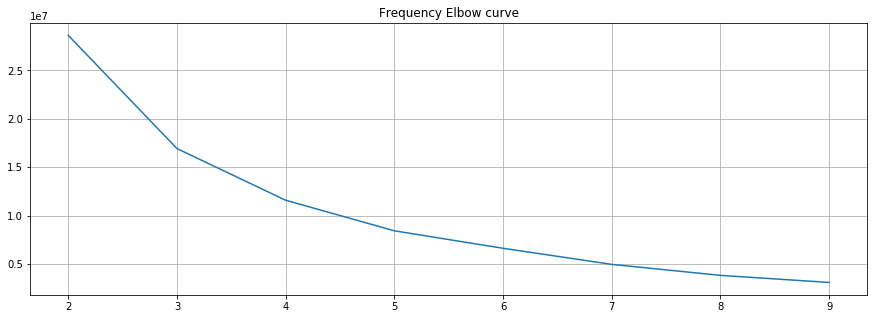

In [93]:
#### Visits kmeans clustering

df_visits = reg[['f']]
#df_normalized[['visits']]

distorsions = []
for k in range(2, 10):
    kmeans = KMeans(n_clusters=k,random_state=10,n_jobs = -1)
    kmeans.fit(df_visits)
    distorsions.append(kmeans.inertia_)

fig = plt.figure(figsize=(15, 5))
plt.plot(range(2, 10), distorsions)
plt.grid(True)
plt.title('Frequency Elbow curve')



In [94]:
# kmeans clustering
kmeans = KMeans(n_clusters=6,n_jobs = -1)

kmeans.fit(reg[['f']])

reg['visitsCluster'] = kmeans.predict(reg[['f']])

In [95]:
# Ordering the visits clustersreg.groupby(['RecencyCluster'])['Recency'].describe()
reg = order_cluster('visitsCluster', 'f',reg,True)

In [9]:
#reg.groupby(['visitsCluster'])['f'].describe()

In [10]:
#from matplotlib.pyplot import figure
#figure(num=None, figsize=(10, 8), dpi=80, facecolor='w', edgecolor='k')
#plt.hist(reg[reg['Vol_sum']<2000]['Vol_sum'], bins=50, alpha=0.5, label='Vol', color='b')
#plt.title('Customer Volume')
#plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)

In [136]:
(reg[reg['V']>1500].shape[0]/reg.shape[0])*100

0.45270839996510914

Text(0.5, 1.0, 'Volume Elbow curve')

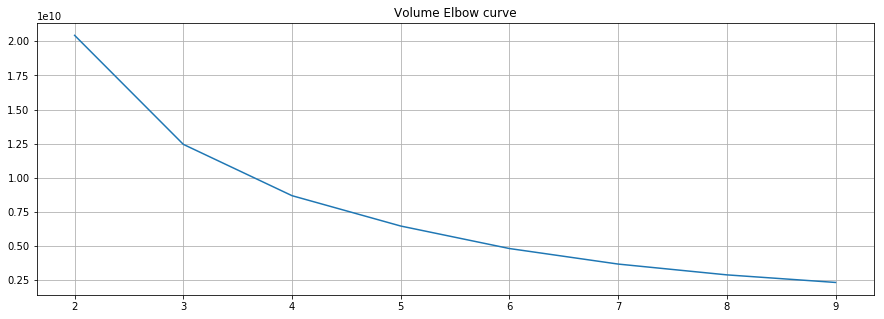

In [102]:
#### volume kmeans clustering

df_visists = reg[['V']]
#df_normalized[['visits']]

distorsions = []
for k in range(2, 10):
    kmeans = KMeans(n_clusters=k,random_state=10,n_jobs = -1)
    kmeans.fit(df_visists)
    distorsions.append(kmeans.inertia_)

fig = plt.figure(figsize=(15, 5))
plt.plot(range(2, 10), distorsions)
plt.grid(True)
plt.title('Volume Elbow curve')


In [103]:
#Volume kmeans clustering
kmeans = KMeans(n_clusters=5,n_jobs = -1)

kmeans.fit(reg[['V']])

reg['VCluster'] = kmeans.predict(reg[['V']])

In [104]:
reg = order_cluster('VCluster', 'V',reg,True)

In [11]:
#reg.groupby(['VCluster'])['V'].describe()

Text(0.5, 1.0, 'Elbow curve')

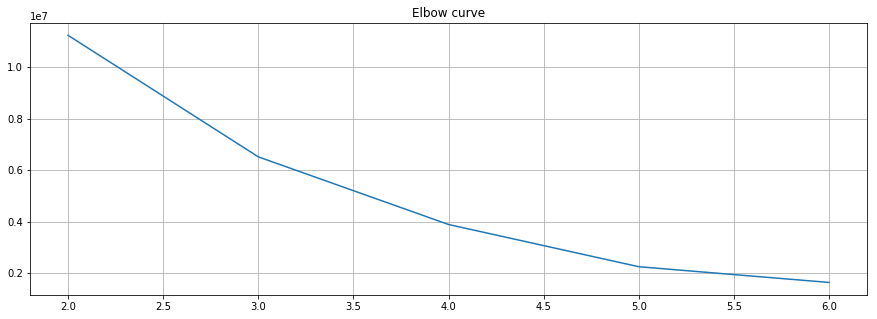

In [31]:
#### avg_lag kmeans clustering

df_vol_sum = reg[['dis_per_visit']]
#df_normalized[['avg_lag']]

distorsions = []
for k in range(2, 7):
    kmeans = KMeans(n_clusters=k,random_state=10)
    kmeans.fit(df_vol_sum)
    distorsions.append(kmeans.inertia_)

fig = plt.figure(figsize=(15, 5))
plt.plot(range(2, 7), distorsions)
plt.grid(True)
plt.title('Discount per Visit Elbow curve')


In [47]:
#Discount kmeans clustering
kmeans = KMeans(n_clusters=4,n_jobs = -1)

kmeans.fit(reg[['dis_per_v']])

reg['Disc_Cluster'] = kmeans.predict(reg[['dis_per_v']])

In [48]:
reg = order_cluster('Disc_Cluster', 'dis_per_v',reg,True)

In [12]:
#reg.groupby(['Disc_Cluster'])['dis_per_visit'].describe()

In [13]:
#avg_lag kmeans clustering
kmeans = KMeans(n_clusters=4,n_jobs = -1)

kmeans.fit(reg[['Ave_lag']])

reg['Lag_Cluster'] = kmeans.predict(reg[['Ave_lag']])

reg = order_cluster('Lag_Cluster', 'Ave_lag',reg,False)

reg.groupby(['Lag_Cluster'])['Ave_lag'].describe()

In [14]:
#Create a scoring

reg['OverallScore'] = reg['RecencyCluster'] + reg['visitsCluster'] + reg['VCluster']+ reg['Disc_Cluster']+ reg['Lag_Cluster']

#Visualizing the scores to see if we can see distinct clusters

from matplotlib.pyplot import figure
figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
plt.hist(reg['OverallScore'] , bins=100, alpha=0.5, label='Overal Score', color='b')
plt.title('Customer Overal Score')
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)



Text(0.5, 1.0, 'OverallScore Elbow curve')

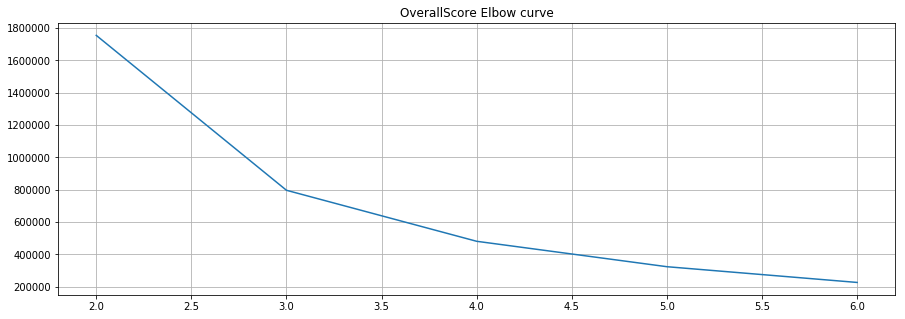

In [107]:
df_vol_sum = reg[['OverallScore']]
#df_normalized[['avg_lag']]

distorsions = []
for k in range(2, 7):
    kmeans = KMeans(n_clusters=k,random_state=10)
    kmeans.fit(df_vol_sum)
    distorsions.append(kmeans.inertia_)

fig = plt.figure(figsize=(15, 5))
plt.plot(range(2, 7), distorsions)
plt.grid(True)
plt.title('OverallScore Elbow curve')

In [108]:
#Overal Score kmeans clustering
kmeans = KMeans(n_clusters=3,n_jobs = -1)

kmeans.fit(reg[['OverallScore']])

reg['OverallScoreCluster'] = kmeans.predict(reg[['OverallScore']])

In [109]:
reg = order_cluster('OverallScoreCluster', 'OverallScore',reg,True)

In [15]:
#reg.groupby(['OverallScoreCluster'])['OverallScore'].describe()

In [61]:
#Labeling the segments by clustering

reg['Segment_clustered'] = 'Low-Value'

reg.loc[reg['OverallScoreCluster']==1,'Segment_clustered'] = 'Mid-Value' 

reg.loc[reg['OverallScoreCluster']==2,'Segment_clustered'] = 'High-Value' 

In [71]:
#Labeling the segments by rules
reg['Segment_ruled'] = 'Low-Value'

reg.loc[reg['OverallScore']>=5.5,'Segment_ruled'] = 'Mid-Value' 

reg.loc[reg['OverallScore']>=9.5,'Segment_ruled'] = 'High-Value' 

In [16]:
# Visualizing the segments

#Volume vs Frequency with score clustering

#data = reg.query("V < 5000 and f < 100")
#groups = data.groupby(['Segment_clustered'])

#from matplotlib.pyplot import figure

#fig,ax = plt.subplots()
#ax.margins(0.05) 
#for name, group in groups:
 #   ax.plot(group['f'], group['V'], marker='o', linestyle='',  label=name,ms=group['OverallScore'].max())
#ax.legend()


#plt.show()


In [17]:
#Volume vs Frequency with rulebased segmenting

data = reg.query("Vol_sum < 5000 and visits < 100")
groups = data.groupby(['Segment_ruled'])

from matplotlib.pyplot import figure

fig,ax = plt.subplots()
ax.margins(0.05) 
for name, group in groups:
    ax.plot(group['visits'], group['Vol_sum'], marker='o', linestyle='', label=name,ms=group['OverallScore'].max())
ax.legend()


plt.show()


# Clustering based on all the normalized features at once

###  Normalizing features to make sure they are comparable. 
#### I've decided to scale to min and max. However, normalizing to $\sigma$ = 1 and $\mu$ = 0 is also another good approach to consider.

In [164]:

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import Normalizer

from sklearn import preprocessing

scaler = StandardScaler()

#### normalizing the data


for_scale =reg[['Recency','f','V','dis_per_v','Ave_lag']]
cols = for_scale.columns
min_max_scaler = preprocessing.MinMaxScaler()
for_scaled = min_max_scaler.fit_transform(for_scale)

df_normalized = pd.DataFrame(for_scaled, columns = cols,index = for_scale.index)


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:334: DataConversionWarning:

Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.



In [ ]:
for_scale =reg[['Recency','f','V','dis_per_v','Ave_lag']]
cols = for_scale.columns
robust_scaler = preprocessing.RobustScaler()
for_scaled = robust_scaler.fit_transform(for_scale)

df_robust = pd.DataFrame(for_scaled, columns = cols,index = for_scale.index)


Text(0.5, 1.0, 'Multivariat clustering Elbow curve')

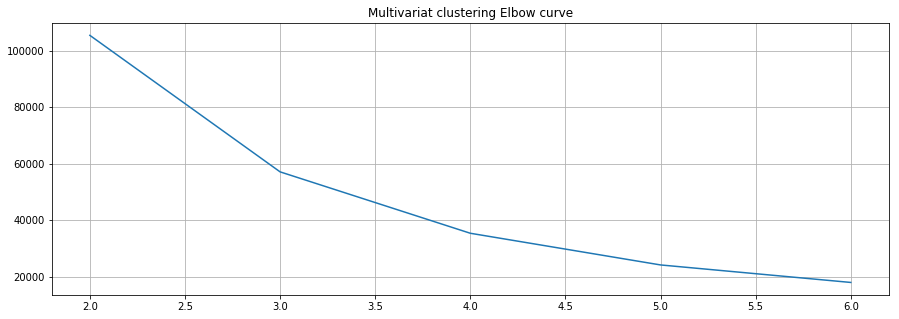

In [154]:
# Multivariat clustering

distorsions = []
for k in range(2, 7):
    kmeans = KMeans(n_clusters=k,random_state=10)
    kmeans.fit(df_normalized )
    distorsions.append(kmeans.inertia_)

fig = plt.figure(figsize=(15, 5))
plt.plot(range(2, 7), distorsions)
plt.grid(True)
plt.title('Multivariat clustering Elbow curve')

In [201]:
# Multivariat clustering, scaled

kmeans = KMeans(n_clusters=4,n_jobs = -1)


kmeans.fit(df_normalized)

df_normalized['Segments_multivar'] = kmeans.predict(df_normalized)

In [202]:
# Merging with initial dataset
all = pd.merge(reg, df_normalized, left_index=True, right_index=True,suffixes=('_orig','_Scaled'))


In [18]:
#all.groupby(['Segments_multivar'])['Recency_orig'].describe()

In [19]:
#all.groupby(['Segments_multivar'])['visits_orig'].describe()

In [20]:
#all.groupby(['Segments_multivar'])['Vol_sum_orig'].describe()

In [185]:
# Multivariat clustering, non-scaled

kmeans = KMeans(n_clusters=3,n_jobs = -1)

for_scale =reg[['Recency','f','V','dis_per_v']]
kmeans.fit(for_scale)

for_scale['Segments_multivar'] = kmeans.predict(for_scale)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



In [187]:
all = pd.merge(reg, for_scale, left_index=True, right_index=True,suffixes=('1','2'))

In [21]:
#all.groupby(['Segments_multivar'])['Recency1'].describe()

In [196]:
# Multivariat clustering, robust scaled to  minimize the outlier effect

kmeans = KMeans(n_clusters=4,n_jobs = -1)

##for_scale =reg[['Recency','visits','Vol_sum','dis_per_visit']]
kmeans.fit(df_robust)

df_robust['Segments_multivar'] = kmeans.predict(df_robust)

In [198]:
all = pd.merge(reg, df_robust, left_index=True, right_index=True,suffixes=('1','2'))

In [22]:
#all.groupby(['Segments_multivar'])['Recency1'].describe()